<center>
<h1><br/></h1>
<h1>INF581A: Advanced Deep Learning</h1>
<h2>Lab 5: Transformer and Transfer Learning</h2>

<h5>Tuesday, February 04, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit to Moodle a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>February 11
, 2025 11:59 AM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>

<h3><b>1. Introduction:</b></h2>
<p style="text-align: justify;">
Transfer learning that is, solving tasks with models that have been pretrained on very large amounts of data, was a game changer in many deep learning tasks. In NLP, while annotated data are scarce, raw text is virtually unlimited and readily available. Thus, the ability to learn good representations from plain text could greatly improve general natural language understanding. Learning without labels is enabled via self-supervised learning, a setting in which a system learns to predict part of its input from other parts of its input.

<p>One way to realise this pre-training is to use <i>generative pre-training</i> <a href="https://www.cs.ubc.ca/~amuham01/LING530/papers/radford2018improving.pdf" target='_blank'>[1]</a> of a language model. In this pre-training phase, the model will learn to predict the next tokens in a sequence given the previous ones.</p>
<p>Thus, this phase does not require any type of annotations apart from the input text itself. Once the language model is sufficiently pre-trained, it can be fine-tuned on supervised tasks while requiring minimal changes to its architecture (replacing the classification head).</p>

In this lab we will:
<ul>
    <li>Implement and pretrain a language model with transformer architecture.</li>
    <li>Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.</li>
    <li>Compare the performance of the pretrained model to a model trained from scratch.</li>
</ul>

<h3><b>2. The Model:</b></h3>
<p style="text-align: justify;">

Our model is based on Transformers<a href="https://arxiv.org/abs/1706.03762" target='_blank'>[2]</a>. While the Transformer is a model that follows the encoder-decoder structure, it is possible to use only the encoder part (as in BERT) or the decoder part (as in gpt) to perform some specific tasks. In this notebook, we use a multi-layer Transformer decoder for the language model. Fortunatly, PyTorch recent releases include a standard transformer blocks that can be easily used and adapted.

Let's start by implementing the model. The different layers used in this model are the following:

- The embedding layer
- Positional Embedding
- The transformer layers
- Linear layer for decoding and classification
<center>
<img src='https://am3pap003files.storage.live.com/y4m6sN7mGXA8_lmRiUuuAAbecrSrMa1IumytUCiEJEkIKuoKV2uNoqTmo6mU_PadFeMESJTRjNbM3Q9qIRMiXLMxPDBdKKFC5cX5UFslx44IxVGXBAI7Cipp5A38tVQdwrioDNyWAMIbYb7dQTXoa0T6oRDBl1kgGn2D9JV8wuna3Jhrsd3TgPQNZZnoO9ZpmaN?width=815&height=680&cropmode=none' alt="Drawing" width= '500px'/>

The same model can be used for language modeling and classification by just replacing the last layer in the model. This is why we split our model into two modules:

- base module: which consists of the 3 first layers.
- classifier module: which consists of the last layer.

After the pretraining, the parameters of the base model can be "transferred" to the model used in the classfication task, while the classifier module should be replaced by a new head initialized randomly.

Some of the code is adapted from this nice tutorial: <a href="https://pytorch.org/tutorials/beginner/transformer_tutorial.html" target="_blank">https://pytorch.org/tutorials/beginner/transformer_tutorial.html</a>



In [25]:
import math
import matplotlib.pyplot as plt
from typing import Optional, List

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: </b><br>
Fill in the gaps in the `TransformerModel()` class to implement the described model.
<hr style="border:10px solid blue"> </hr>
</font></h4>

### The Model

In [26]:
class TransformerModel(nn.Module):
    def __init__(self,
                 ntoken: int,
                 nhead: int,
                 nhid: int,
                 nlayers: int,
                 dropout: float = 0.5) -> None:
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=nhid,
            nhead=nhead,
            dim_feedforward=nhid,  # here we assume the feedforward dimension equals nhid
            dropout=dropout
            ) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """
        Generate a square mask for the sequence to prevent attention to future tokens.

        Args:
            sz (int): Size of the square mask (sequence length).

        Returns:
            torch.Tensor: Mask tensor of shape [sz, sz].
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self) -> None:
        """Initialize the weights of the encoder."""
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,
                src: torch.Tensor,
                src_mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the Transformer model.

        Args:
            src (torch.Tensor): Input tensor of shape [seq_len, batch_size].
            src_mask (torch.Tensor): Square subsequent mask of shape [seq_len, seq_len].

        Returns:
            torch.Tensor: Output tensor from the transformer encoder.
        """
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self,
                 nhid: int,
                 nclasses: int) -> None:
        """
        Initialize the classification head.

        Args:
            nhid (int): Hidden dimension size.
            nclasses (int): Number of output classes.
        """
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self) -> None:
        """Initialize the weights of the decoder."""
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the classification head.

        Args:
            src (torch.Tensor): Input tensor from the Transformer model.

        Returns:
            torch.Tensor: Logits for each class.
        """
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self,
                 ntoken: int,
                 nhead: int,
                 nhid: int,
                 nlayers: int,
                 nclasses: int,
                 dropout: float = 0.5) -> None:
        """
        Initialize the complete model combining the Transformer base and the classification head.

        Args:
            ntoken (int): Vocabulary size.
            nhead (int): Number of attention heads.
            nhid (int): Hidden dimension size.
            nlayers (int): Number of Transformer encoder layers.
            nclasses (int): Number of output classes.
            dropout (float, optional): Dropout probability. Defaults to 0.5.
        """
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self,
                src: torch.Tensor,
                src_mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the full model.

        Args:
            src (torch.Tensor): Input tensor of shape [seq_len, batch_size].
            src_mask (torch.Tensor): Mask tensor of shape [seq_len, seq_len].

        Returns:
            torch.Tensor: Output logits from the classifier.
        """
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        return output

In [27]:
class PositionalEncoding(nn.Module):
  # for a more in depth explanation we encourage you to read:
  # https://medium.com/swlh/elegant-intuitions-behind-positional-encodings-dc48b4a4a5d1
    def __init__(self,
                 nhid: int,
                 dropout: float = 0.1,
                 max_len: int = 5000) -> None:
        """
        Initialize the PositionalEncoding module.

        Args:
            nhid (int): The hidden (and embedding) dimension.
            dropout (float, optional): Dropout probability. Defaults to 0.1.
            max_len (int, optional): Maximum length for which to precompute positional encodings. Defaults to 5000.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self,
                x: Tensor) -> Tensor:
        """
        Add positional encodings to the input embeddings.

        Args:
            x (Tensor): Input tensor of shape [sequence_length, batch_size, embedding_dim].

        Returns:
            Tensor: Tensor with positional encodings added, of the same shape as input.
        """
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1 (4 points): </b><br>
What is the role of the square mask in our implementation? What about the positional encoding?
<hr style="border:10px solid red"> </hr>
</font></h4>








<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 1: </b><br>

#### Square Mask

It prevents a token from “seeing” future tokens during attention computations.

The mask is a square matrix (of shape```[sequence_length, sequence_length]```) that prevents a given token from attending to tokens that come later in the sequence. It does this by setting the attention scores for future tokens to negative infinity, so that after applying the softmax, these positions contribute effectively zero weight.

This ensures that when predicting a token at position $i$, the model only uses information from positions $ ≤ i$, thus avoiding any information leakage from the future.


#### Positional Encoding

It gives ordering information into the input embeddings, allowing the transformer to differentiate between tokens based on their positions in the sequence.

The positional encoding is added to the token embeddings and typically uses sinusoidal functions to generate a unique positional representation for each token based on its index in the sequence. So the model gains access to information about the relative or absolute position of tokens in the sequence, enabling it to capture sequential relationships.

<hr style="border:10px solid green"> </hr>
</font></h4>



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2 (2 points): </b><br>
Why do we have to replace the classification head? What is the main difference between the <i>language modeling</i> and the <i>classification</i> tasks?
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 2: </b><br>

The current model learns to predict the next word by outputting scores for every word in a large vocabulary. For the classification task (like deciding if a review is positive or negative), we only need to pick one label out of a few options. That’s why we remove the pretraining head and replace it with a new one designed to give just a few outputs (one for each class).

In language modeling, the goal is to predict the next word at each step, so the model works at the word level. In contrast, classification requires the model to look at the whole sentence or review and decide on one overall label.

```Example:```
- For language modeling:  given the input "The cat sat on the", the model predicts the next word from a vocabulary of 10,000 words.
- For sentiment classification: given a full review like "The movie was fantastic", the model only needs to decide between 2 labels: positive or negative.

That's why we replace the head: the original head outputs 10,000 options, but for classification we only need 2.

<hr style="border:10px solid green"> </hr>
</font></h4>



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3 (6 points): </b><br>
How many trainable parameters does the model have in the case of <br>
<ul>
<font color='red'>
    <li><i>language modeling</i> task.</li>
    <li><i>classification</i> task.</li>
</ul>
Please detail your answer. You can omit the biases and the parameters of normalization layers.<br>
<hr style="border:10px solid red"> </hr>
</font></h4>



<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 3: </b><br>

We denote:
- $$V = vocabulary\ size $$

- $$d = hidden\ (and\ embedding)\ dimension$$
- $$L = number\ of\ Transformer\ layers$$
- $$C = number\ of\ classes\ (for\ language\ modeling, C = V; for\ classification, e.g., C = 2)$$

---

1. **Embedding Layer**  
   The embedding layer has:  
   $$\text{Parameters} = V \times d = Vd$$

2. **Transformer Encoder Layers**  
   Each Transformer layer consists of two parts:

   ** Multi-head Self-Attention:**  
   - Combined projection for query, key, and value: $3d^2$  
   - Output projection: $d^2$  
     
   Total for attention: $3d^2 + d^2 = 4d^2$

   **Feed-Forward Network:**  
   - First linear layer: $d^2$  
   - Second linear layer: $d^2$  
     
   Total for feed-forward: $d^2 + d^2 = 2d^2$

   **Total per layer:** $4d^2 + 2d^2 = 6d^2$

   For $L$ layers, the total is: $6L\,d^2$

3. **Final Linear Layer**  
   This layer maps from the hidden dimension to the output dimension: $\text{Parameters} = d \times C = dC$

---

**Overall Total Trainable Parameters:**  $\text{Total} = Vd + 6L\,d^2 + dC$

---

- **For the Language Modeling Task:**  
  Here, the output layer predicts over the entire vocabulary, so $C = V$. Then,  
  $$\text{Total}_{\text{LM}} = Vd + 6L\,d^2 + dV = 2Vd + 6L\,d^2$$

- **For the Classification Task:**  
  For example, if there are 2 classes, then $C = 2$. Thus,  
  $$\text{Total}_{\text{CLS}} = Vd + 6L\,d^2 + 2d$$


<hr style="border:10px solid green"> </hr>
</font></h4>


Let's verify if our model works, by applying one inference step

In [28]:
ntokens = 100  # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?
# Yes the shape is right
# torch.Size([1, 6, 100])

torch.Size([1, 6, 100])


## 3.Vocabulary and Tokenization

To train the language model, the text in our corpus should be first tokenized. We use sentencepiece <a href="https://github.com/google/sentencepiece">https://github.com/google/sentencepiece</a> that implements byte-pair-encoding (BPE), a sub-word tokenization algorithm.<br>
The vocabulay is given in <code>dict.txt</code> file. Let's load it, and map each token to a unique index.<br>

In our experiments we use datasets that are already tokenized.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: </b><br>
Fill in the gaps to create a <code>token2ind</code> and <code>ind2token</code> mapping dictionaries
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [29]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2025-02-11 09:43:07--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt.1’

dict.txt.1          100%[===================>] 564.05K  --.-KB/s    in 0.007s  

2025-02-11 09:43:08 (83.7 MB/s) - ‘dict.txt.1’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [30]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
offset = len(token2ind)

with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + offset

ind2token =  {v: k for k, v in token2ind.items()}

print(ind2token[1111])

▁trop


## 4.Data Loader
We use the <code>DataLoader</code> class, to load our dataset and generate the mini-batches used in the training. <code>get_loader()</code> returns a <code>DataLoader</code>  object, which is an iterable over data samples. The data loader can return mini-batches for language modeling or sequence classification based on the <code>task</code> argument that we pass to <code>get_loader()</code> function. Currently the function supports <i>language_modeling</i> and <i>classification</i> tasks.<br>

For the <i>language_modeling</i> task, both the input and the target are batches of sequences. In fact, the target is basically a shifted version of
the input, in such a way that each token is predicted given all previous tokens. For example, for a sequence A B C D: <br>
<b>Input:</b><code>\<sos\></code>A B C D<br>
<b>Output:</b>A B C D<code>\<eos\></code><br>

For the <i>classification</i> task,
the input is a batch of sequences and
the target is a batch of scalar labels.<br>
For more information about data loaders check: <a href="https://pytorch.org/docs/stable/data.html">https://pytorch.org/docs/stable/data.html</a>


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Fill in the gap inside <code>Dataset</code> class in order to create the input sequence
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [31]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]] + [
            self.token2ind.get(token, self.token2ind["<oov>"]) for token in sequence
        ]

        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## 5.The Training
In this section we will implement a <code>train()</code> function that trains our model for one epoch. As we said, in this lab we will use a language modeling objective in
the pretraining phase. Given the previous tokens in a sequence,
the model will try to predict
the next one. The same function can be used for both pretraining and fine-tuning phase.<br>

The training procedure is as follows:<br>
1. Iterate over the data-loader.<br>
2. In each iteration perform one forward pass.<br>
3. Compute
the loss through back-propagation.<br>
4. update
the parameters of your model using sgd.<br>
5. repeat for <i>n</i> epochs<br>

<b>N.B:</b>  While in
the <i>language_modeling</i> task all
the vectors at
the output of
the base model are used, in
the <i>classification</i> task we only use
the vector representing
the last token to perform
the prediction.<br>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill in the gaps in <code>train()</code> function.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [32]:
def train(
    path_data_train: str,
    path_labels_train: Optional[str] = None,
    path_data_valid: Optional[str] = None,
    save_interval: int = -1,
    log_interval: int = 5,
    task: str = "language_modeling",
    batch_size: int = 32,
) -> List[float]:
    """
    Trains the model for one epoch on the specified task (language modeling or classification).

    This function loads the training data using a data loader, performs forward passes,
    computes the cross-entropy loss, backpropagates the gradients, and updates the model's
    parameters using an optimizer. It logs the average loss every `log_interval` steps and
    returns a list of these average losses.

    Args:
        path_data_train (str): Path to the training data file.
        path_labels_train (Optional[str]): Path to the training labels file (if applicable).
        path_data_valid (Optional[str]): Path to the validation data file (if applicable).
        save_interval (int): Interval at which to save model checkpoints (default: -1, meaning not used).
        log_interval (int): Number of steps between loss logging (default: 5).
        task (str): Task type, either "language_modeling" or "classification" (default: "language_modeling").
        batch_size (int): Batch size to use during training (default: 32).

    Returns:
        List[float]: A list of average loss values logged during training.
    """
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            # last vector only
            output = output[-1, :]
        output = output.view(-1, output.shape[-1])
        target =  data[1]
        target = target.to(device)
        loss =  criterion(output, target) #fill me, Cross entropy check next cells
        #fill me step 3, backward propagation

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4, optimizer step
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [33]:
ntokens = len(token2ind) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [34]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [35]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2025-02-11 09:43:09--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt.1’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.03s   

2025-02-11 09:43:09 (298 MB/s) - ‘pretraining_subset.txt.1’ saved [10146460/10146460]



In [36]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.30942 | ppl 1494.316
| epoch   1 |  1000/ 3125 steps | loss 6.47200 | ppl  646.778
| epoch   1 |  1500/ 3125 steps | loss 6.20084 | ppl  493.163
| epoch   1 |  2000/ 3125 steps | loss 6.03431 | ppl  417.512
| epoch   1 |  2500/ 3125 steps | loss 5.91701 | ppl  371.299
| epoch   1 |  3000/ 3125 steps | loss 5.83891 | ppl  343.405
| epoch   2 |   500/ 3125 steps | loss 5.52308 | ppl  250.404
| epoch   2 |  1000/ 3125 steps | loss 5.47035 | ppl  237.543
| epoch   2 |  1500/ 3125 steps | loss 5.45543 | ppl  234.027
| epoch   2 |  2000/ 3125 steps | loss 5.41283 | ppl  224.265
| epoch   2 |  2500/ 3125 steps | loss 5.38774 | ppl  218.708
| epoch   2 |  3000/ 3125 steps | loss 5.32871 | ppl  206.173


## 6. Text Generation
Being trained on a language modeling objective, our model can be used in the inference mode to generate/complete sentences. However, the pretraining phase takes a lot of time compared to the fine-tuning. For example, <a href="https://arxiv.org/pdf/1911.03894.pdf">CamemBERT</a><sub>base</sub> <sup>[1]</sup> was pretrained for 24 hours on 256 Nvidia V100 GPUs and <a href="https://arxiv.org/pdf/2010.12321.pdf">BARThez</a> <sup>[2]</sup> was pretrained for 60h on 128 Nvidia V100 GPUs!<br>

Of course, we don't have enough time and resources to efficiently pretrain our model, so instead we will load the weights from a checkpoint that has been pre-trained for 12 hours on 1 GPU.<br>

Take a look here: <a href="https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training">https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training</a><br>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Implement the function <code>infer_next_tokens()</code> that takes as input a string <code>sent</code> and an integer <code>max_len</code> and returns a completion of the input sentence. The generation should stop when the model generates <code>&lt;eos&gt;</code> or the length of the generated sentence reaches <code>max_len</code>
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [37]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2025-02-11 09:46:10--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.1’

pretrained_model_4l 100%[===================>]  84.01M   377MB/s    in 0.2s    

2025-02-11 09:46:11 (377 MB/s) - ‘pretrained_model_4layers.pt.1’ saved [88093955/88093955]



<ipython-input-37-76a40ce8b80e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('pretrained_model_4layers.pt')


<All keys matched successfully>

In [38]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2025-02-11 09:46:14--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model.1’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2025-02-11 09:46:14 (110 MB/s) - ‘sentencepiece.french.model.1’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [39]:
encoded = s.encode_as_pieces("Coucou tout le monde")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁C', 'oucou', '▁tout', '▁le', '▁monde']
Coucou tout le monde


In [40]:
def infer_next_token(sent: str) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generate the next token for a given input sentence using the model.

    This function encodes the input sentence via SentencePiece, prepends a <sos> token,
    and passes the resulting sequence through the model to obtain output logits. It then
    selects the predicted token index from the logits corresponding to the last time step.

    Args:
        sent (str): The input sentence.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: A tuple containing:
            - next_token_ind: The predicted token index (as a torch.Tensor).
            - out: The full output tensor from the model.
    """
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces]
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = out[-1].argmax(-1)
    return next_token_ind, out

def infer_next_tokens(sent: str, max_len: int = 50) -> str:
    """
    Generate a sequence of tokens (text) by iteratively predicting the next token using the model.

    This function encodes the input sentence, then repeatedly predicts the next token until
    the maximum length is reached or an <eos> token is generated. The generated token indices
    are converted back into text using SentencePiece.

    Args:
        sent (str): The initial input sentence.
        max_len (int, optional): The maximum length of the generated sequence (including the initial tokens).
                                 Defaults to 50.

    Returns:
        str: The generated text, with the initial <sos> token removed and truncated at <eos> if present.
    """

    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    # Use get() to default to <oov> if the piece is not in token2ind.
    source_tokens = [token2ind['<sos>']] + [token2ind.get(piece, token2ind['<oov>']) for piece in sent_pieces]

    # Convert to tensor and reshape to [sequence_length, batch_size]
    source = torch.tensor(source_tokens, dtype=torch.long, device=device).unsqueeze(1)

    generated = source_tokens[:]

    while len(generated) < max_len:

        src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
        out = model(source, src_mask)

        next_token_ind = out[-1].argmax(dim=-1).item()
        generated.append(next_token_ind)
        # If the generated token is <eos>, stop.
        if next_token_ind == token2ind['<eos>']:
            break
        # Append the new token to the source tensor so that the model can condition on it in the next step.
        next_token_tensor = torch.tensor([[next_token_ind]], dtype=torch.long, device=device)
        source = torch.cat((source, next_token_tensor), dim=0)

    # Remove the starting <sos> token.
    generated = generated[1:]

    if token2ind['<eos>'] in generated:
        eos_index = generated.index(token2ind['<eos>'])
        generated = generated[:eos_index]


    generated_tokens = [ind2token[idx] for idx in generated]
    # Use SentencePiece to decode the list of pieces back into a string.
    generated_sentence = s.decode_pieces(generated_tokens)
    return generated_sentence

In [41]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques.'

## 7. Supervised task
It's time to train the model on the supervised task, which is in our case sentiment analysis. It consists of predicting whether a book review is a positive or a negative review. The model will be trained in 2 settings.<br>
<ul>
    <li>Training from scratch: All model parameters are randomly initialized.</li>
    <li>Transfer learning: Only the classification head is trained from scratch, all other parameters are copied from the pre-trained model.</li>
</ul>

The training function is already implemented. However, to evaluate the model at each epoch we have to implement a function that computes the accuracy of the model on the validation set.<br>



In [42]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2025-02-11 09:46:14--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm.1’

train.review.spm.1  100%[===================>]   1.43M  --.-KB/s    in 0.007s  

2025-02-11 09:46:14 (214 MB/s) - ‘train.review.spm.1’ saved [1495960/1495960]

--2025-02-11 09:46:14--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: </b><br>
Implement the <code>accuracy()</code> function. This function takes as input a <code>data_loader</code> and returns an float.<br>
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [43]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader: DataLoader) -> float:
    """
    Compute the validation accuracy of the model.

    Args:
        data_loader (DataLoader): DataLoader yielding (src, target) batches.

    Returns:
        float: The accuracy as a fraction.
    """
    #to be implemented
    model.eval()  # set model to evaluation mode
    running_correct = 0
    running_total = 0
    with torch.inference_mode():
        for src, target in data_loader:
            src, target = src.to(device), target.to(device)
            src_mask = model.base.generate_square_subsequent_mask(src.size(0)).to(device)
            logits = model(src, src_mask)
            logits = logits[-1]
            predictions = logits.argmax(dim=-1)
            running_total += target.size(0)
            running_correct += (predictions == target).sum().item()

    return running_correct / running_total

In [44]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [45]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 20
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.78812 | ppl    2.199
| epoch   1 |   100/  200 steps | loss 0.71347 | ppl    2.041
| epoch   1 |   150/  200 steps | loss 0.70207 | ppl    2.018
| epoch   2 |    50/  200 steps | loss 0.64365 | ppl    1.903
| epoch   2 |   100/  200 steps | loss 0.61148 | ppl    1.843
| epoch   2 |   150/  200 steps | loss 0.54338 | ppl    1.722
| epoch   3 |    50/  200 steps | loss 0.30924 | ppl    1.362
| epoch   3 |   100/  200 steps | loss 0.39342 | ppl    1.482
| epoch   3 |   150/  200 steps | loss 0.31671 | ppl    1.373
| epoch   4 |    50/  200 steps | loss 0.07770 | ppl    1.081
| epoch   4 |   100/  200 steps | loss 0.17770 | ppl    1.194
| epoch   4 |   150/  200 steps | loss 0.15335 | ppl    1.166
| epoch   5 |    50/  200 steps | loss 0.02882 | ppl    1.029
| epoch   5 |   100/  200 steps | loss 0.03972 | ppl    1.041
| epoch   5 |   150/  200 steps | loss 0.02847 | ppl    1.029
| epoch   6 |    50/  200 steps | loss

<ipython-input-45-4aa28422da9e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")


| epoch   1 |    50/  200 steps | loss 0.81386 | ppl    2.257
| epoch   1 |   100/  200 steps | loss 0.68024 | ppl    1.974
| epoch   1 |   150/  200 steps | loss 0.57954 | ppl    1.785
| epoch   2 |    50/  200 steps | loss 0.45448 | ppl    1.575
| epoch   2 |   100/  200 steps | loss 0.50390 | ppl    1.655
| epoch   2 |   150/  200 steps | loss 0.50461 | ppl    1.656
| epoch   3 |    50/  200 steps | loss 0.40920 | ppl    1.506
| epoch   3 |   100/  200 steps | loss 0.39354 | ppl    1.482
| epoch   3 |   150/  200 steps | loss 0.41608 | ppl    1.516
| epoch   4 |    50/  200 steps | loss 0.31283 | ppl    1.367
| epoch   4 |   100/  200 steps | loss 0.26256 | ppl    1.300
| epoch   4 |   150/  200 steps | loss 0.36013 | ppl    1.434
| epoch   5 |    50/  200 steps | loss 0.18958 | ppl    1.209
| epoch   5 |   100/  200 steps | loss 0.19260 | ppl    1.212
| epoch   5 |   150/  200 steps | loss 0.17842 | ppl    1.195
| epoch   6 |    50/  200 steps | loss 0.07593 | ppl    1.079
| epoch 

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 7: </b><br>
Visualize the evolution of the accuracy of the model in function of the epoch in both settings.
<hr style="border:10px solid blue"> </hr>
</font></h4>

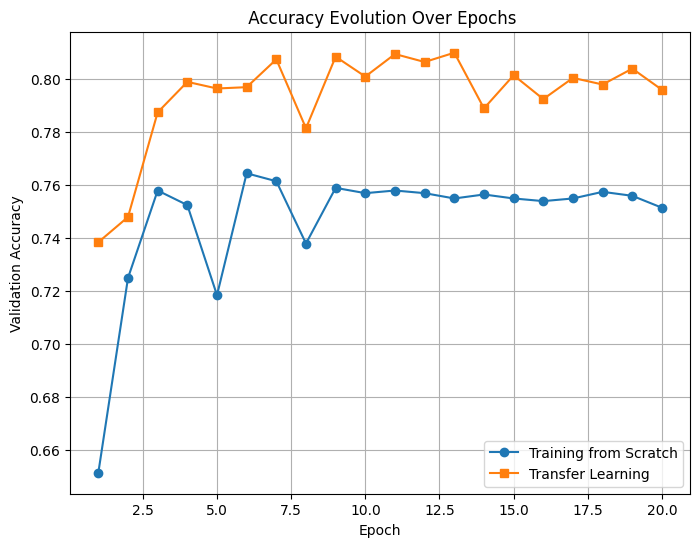

In [46]:
# Create a list of epoch numbers. For example, if you ran 15 epochs:
epochs = range(1, len(from_scratch_valid_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, from_scratch_valid_acc, marker='o', label='Training from Scratch')
plt.plot(epochs, pretrained_valid_acc, marker='s', label='Transfer Learning')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title(" Accuracy Evolution Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 4 (4 points): </b><br>
Interpret the results.
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 4: </b><br>

The graph shows that the transfer learning curve is always higher than the training-from-scratch curve. This means that a model starting with pre-trained weights gets higher accuracy at every epoch compared to one that starts with random weights.

In other words, the pre-trained model already contains useful feature representations that allow it to learn the classification task more quickly and effectively, resulting in faster convergence and better overall performance than starting with random weights.
<hr style="border:10px solid green"> </hr>
</font></h4>


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 5 (4 points): </b><br>
What is one of the limitations of the language modeling objective used in this notebook, compared to the masked language model objective introduced in <a href="https://arxiv.org/abs/1810.04805" target="_blank">Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.</a><br>
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 5: </b><br>

One limitation of the autoregressive language modeling objective used here is that it is unidirectional and suffers from exposure bias, meaning the model is trained only on correct previous tokens and not on its own predictions. In contrast, consider the T5 model, which uses a span corruption objective (a variant of masked language modeling). T5 masks contiguous spans of text and trains the model to generate these missing spans using context from both the left and right. This bidirectional approach captures richer contextual information and mitigates the exposure bias problem.
<hr style="border:10px solid green"> </hr>
</font></h4>
